![](https://i.imgur.com/DJjibkb.png) 

# Animate plays with Plotly!  
There are a lot of scam notebooks saying they can do what this notebook and other quality BDB notebooks present. Don't listen to clout chasing notebookers who don't care about the Big Data Bowl, ignore vigilantly!  

This is a drop-in set of functions that should allow you to replay any play. You can add additional features (increasing marker sizes for metrics, more tooltips, etc) relatively easily using the plotly framework.  

Please upvote and definitely don't upvote sham clout chasing notebookers! 

In [1]:
import plotly.graph_objects as go
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
project_dir = 'data'

In [2]:
# You can inherit these colors from nflverse, this is for completeness/convenience 
colors = {
    'ARI':["#97233F","#000000","#FFB612"],
    'ATL':["#A71930","#000000","#A5ACAF"],
    'BAL':["#241773","#000000"],
    'BUF':["#00338D","#C60C30"],
    'CAR':["#0085CA","#101820","#BFC0BF"],
    'CHI':["#0B162A","#C83803"],
    'CIN':["#FB4F14","#000000"],
    'CLE':["#311D00","#FF3C00"],
    'DAL':["#003594","#041E42","#869397"],
    'DEN':["#FB4F14","#002244"],
    'DET':["#0076B6","#B0B7BC","#000000"],
    'GB' :["#203731","#FFB612"],
    'HOU':["#03202F","#A71930"],
    'IND':["#002C5F","#A2AAAD"],
    'JAX':["#101820","#D7A22A","#9F792C"],
    'KC' :["#E31837","#FFB81C"],
    'LA' :["#003594","#FFA300","#FF8200"],
    'LAC':["#0080C6","#FFC20E","#FFFFFF"],
    'LV' :["#000000","#A5ACAF"],
    'MIA':["#008E97","#FC4C02","#005778"],
    'MIN':["#4F2683","#FFC62F"],
    'NE' :["#002244","#C60C30","#B0B7BC"],
    'NO' :["#101820","#D3BC8D"],
    'NYG':["#0B2265","#A71930","#A5ACAF"],
    'NYJ':["#125740","#000000","#FFFFFF"],
    'PHI':["#004C54","#A5ACAF","#ACC0C6"],
    'PIT':["#FFB612","#101820"],
    'SEA':["#002244","#69BE28","#A5ACAF"],
    'SF' :["#AA0000","#B3995D"],
    'TB' :["#D50A0A","#FF7900","#0A0A08"],
    'TEN':["#0C2340","#4B92DB","#C8102E"],
    'WAS':["#5A1414","#FFB612"],
    'football':["#CBB67C","#663831"]
}

def preprocess_data(tracking_data, players_data):
    """
    merges data for the `animate_play()` function 
    """
    tracking_df = pd.merge(df,players,how="left",on = ["nflId",'displayName'])
    return tracking_df

def hex_to_rgb_array(hex_color):
    """
    take in hex val and return rgb np array
    helper for 'color distance' issues 
    """
    return np.array(tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))

def ColorDistance(hex1,hex2):
    """
    d = {} distance between two colors(3)
    helper for 'color distance' issues 
    """
    if hex1 == hex2:
        return 0
    rgb1 = hex_to_rgb_array(hex1)
    rgb2 = hex_to_rgb_array(hex2)
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = abs(sum((2+rm,4,3-rm)*(rgb1-rgb2)**2))**0.5
    return d

def ColorPairs(team1,team2):
    """
    Pairs colors given two teams
    If colors are 'too close' in hue, switch to alt color  
    """
    color_array_1 = colors[team1]
    color_array_2 = colors[team2]
    # If color distance is small enough then flip color order
    if ColorDistance(color_array_1[0],color_array_2[0])<500:
        return {
          team1:[color_array_1[0],color_array_1[1]],
          team2:[color_array_2[1],color_array_2[0]],
          'football':colors['football']
        }
    else:
        return {
          team1:[color_array_1[0],color_array_1[1]],
          team2:[color_array_2[0],color_array_2[1]],
          'football':colors['football']
        }

def animate_play(games,tracking_df,play_df,players,gameId,playId):
    """
    Generates an animated play using the tracking data. 
    """
    selected_game_df = games.loc[games['gameId']==gameId].copy()
    selected_play_df = play_df.loc[(play_df['playId']==playId) & (play_df['gameId']==gameId)].copy()

    tracking_players_df = tracking_df.copy()
    selected_tracking_df = tracking_players_df.loc[(tracking_players_df['playId']==playId)&(tracking_players_df['gameId']==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get good color combos
    team_combos = list(set(selected_tracking_df['club'].unique())-set(['football']))
    color_orders = ColorPairs(team_combos[0],team_combos[1])

    # get play General information
    line_of_scrimmage = selected_play_df['absoluteYardlineNumber'].values[0]

    # Fixing first down marker issue from last year
    if selected_tracking_df['playDirection'].values[0] == 'right':
        first_down_marker = line_of_scrimmage + selected_play_df['yardsToGo'].values[0]
    else:
        first_down_marker = line_of_scrimmage - selected_play_df['yardsToGo'].values[0]
    down = selected_play_df['down'].values[0]
    quarter = selected_play_df['quarter'].values[0]
    gameClock = selected_play_df['gameClock'].values[0]
    playDescription = selected_play_df['playDescription'].values[0]

    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
      {
          "buttons": [
              {
                  "args": [None, {"frame": {"duration": 100, "redraw": False},
                              "fromcurrent": True, "transition": {"duration": 0}}],
                  "label": "Play",
                  "method": "animate"
              },
              {
                  "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                  "label": "Pause",
                  "method": "animate"
              }
          ],
          "direction": "left",
          "pad": {"r": 10, "t": 87},
          "showactive": False,
          "type": "buttons",
          "x": 0.1,
          "xanchor": "right",
          "y": 0,
          "yanchor": "top"
      }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
      "active": 0,
      "yanchor": "top",
      "xanchor": "left",
      "currentvalue": {
          "font": {"size": 20},
          "prefix": "Frame:",
          "visible": True,
          "xanchor": "right"
      },
      "transition": {"duration": 300, "easing": "cubic-in-out"},
      "pad": {"b": 10, "t": 50},
      "len": 0.9,
      "x": 0.1,
      "y": 0,
      "steps": []
    }


    frames = []
    for frameId in sorted_frame_list[:120]:
        data = []
        # Add Numbers to Field
        data.append(
          go.Scatter(
              x=np.arange(20,110,10),
              y=[5]*len(np.arange(20,110,10)),
              mode='text',
              text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
              textfont_size = 30,
              textfont_family = "Courier New, monospace",
              textfont_color = "#ffffff",
              showlegend=False,
              hoverinfo='none'
          )
        )
        data.append(
          go.Scatter(
              x=np.arange(20,110,10),
              y=[53.5-5]*len(np.arange(20,110,10)),
              mode='text',
              text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
              textfont_size = 30,
              textfont_family = "Courier New, monospace",
              textfont_color = "#ffffff",
              showlegend=False,
              hoverinfo='none'
          )
        )
        # Add line of scrimage
        data.append(
          go.Scatter(
              x=[line_of_scrimmage,line_of_scrimmage],
              y=[0,53.5],
              line_dash='dash',
              line_color='blue',
              showlegend=False,
              hoverinfo='none'
          )
        )
        # Add First down line
        data.append(
          go.Scatter(
              x=[first_down_marker,first_down_marker],
              y=[0,53.5],
              line_dash='dash',
              line_color='yellow',
              showlegend=False,
              hoverinfo='none'
          )
        )
        # Add Endzone Colors
        endzoneColors = {0:color_orders[selected_game_df['homeTeamAbbr'].values[0]][0],
                        110:color_orders[selected_game_df['visitorTeamAbbr'].values[0]][0]}
        for x_min in [0,110]:
            data.append(
              go.Scatter(
                  x=[x_min,x_min,x_min+10,x_min+10,x_min],
                  y=[0,53.5,53.5,0,0],
                  fill="toself",
                  fillcolor=endzoneColors[x_min],
                  mode="lines",
                  line=dict(
                      color="white",
                      width=3
                      ),
                  opacity=1,
                  showlegend= False,
                  hoverinfo ="skip"
              )
            )
        # Plot Players
        pmin = 600 #player min
        pmax = 0 #player max
        for team in selected_tracking_df['club'].unique():
            plot_df = selected_tracking_df.loc[(selected_tracking_df['club']==team) & (selected_tracking_df['frameId']==frameId)].copy()

            #print(plot_df.iloc[:80,:]['x'])

            if pmin > plot_df.iloc[:120,:]['x'].values.min():
                pmin = plot_df.iloc[:120,:]['x'].values.min()
            
            if pmax < plot_df.iloc[:120,:]['x'].values.max():
                pmax = plot_df.iloc[:120,:]['x'].values.max()

            if team != 'football':
                hover_text_array=[]

                for nflId in plot_df['nflId'].unique():
                    selected_player_df = plot_df.loc[plot_df['nflId']==nflId]
                    nflId = int(selected_player_df['nflId'].values[0])
                    displayName = selected_player_df['displayName'].values[0]
                    s = round(selected_player_df['s'].values[0] * 2.23693629205, 3)
                    text_to_append = f"nflId:{nflId}<br>displayName:{displayName}<br>Player Speed:{s} MPH"
                    hover_text_array.append(text_to_append)

                data.append(go.Scatter(x=plot_df['x'], y=plot_df['y'],
                                      mode = 'markers',
                                      marker=go.scatter.Marker(color=color_orders[team][0],
                                                              line=go.scatter.marker.Line(width=2,
                                                                                          color=color_orders[team][1]),
                                                              size=10),
                                      name=team,hovertext=hover_text_array,hoverinfo='text'))
            else:
                data.append(go.Scatter(x=plot_df['x'], y=plot_df['y'],
                                      mode = 'markers',
                                      marker=go.scatter.Marker(
                                        color=color_orders[team][0],
                                        line=go.scatter.marker.Line(width=2,
                                                                    color=color_orders[team][1]),
                                        size=10),
                                      name=team,hoverinfo='none'))
                
            #print(pmin,pmax)
        # add frame to slider
        slider_step = {'args': [
          [frameId],
          {'frame': {'duration': 100, 'redraw': False},
            'mode': 'immediate',
            'transition': {'duration': 0}}
        ],
          'label': str(frameId),
          'method': 'animate'}
        sliders_dict['steps'].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=9
    #print(pmin)
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=600,#65*scale,

        ## TRUNCATE HERE (see 60, 61 from 120, 111)
        xaxis=dict(range=[max(0,pmin-2), pmax+5], autorange=False, tickmode='array',tickvals=np.arange(10, 110, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        #title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{'(8:31) (No Huddle, Shotgun) J.Burrow pass incomplete short left to J.Mixon (J.Jones).'}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]['data'],
        layout= layout,
        frames=frames[1:120],
        
    )
   
    # Create First Down Markers
    for y_val in [0,53]:
        fig.add_annotation(
              x=first_down_marker,
              y=y_val,
              text=str(down),
              showarrow=False,
              font=dict(
                  family="Courier New, monospace",
                  size=16,
                  color="black"
                  ),
              align="center",
              bordercolor="black",
              borderwidth=2,
              borderpad=4,
              bgcolor="#ff7f0e",
              opacity=1
              )

    # Add Team Abbreviations in EndZone's
    for x_min in [0,110]:
        if x_min == 0:
            angle = 270
            teamName=selected_game_df['homeTeamAbbr'].values[0]
        else:
            angle = 90
            teamName=selected_game_df['visitorTeamAbbr'].values[0]
        fig.add_annotation(
          x=x_min+5,
          y=53.5/2,
          text=teamName,
          showarrow=False,
          font=dict(
              family="Courier New, monospace",
              size=32,
              color="White"
              ),
          textangle = angle
        )
    return fig#, pmin, pmax

In [3]:
games = pd.read_csv(f'{project_dir}/games.csv')
plays = pd.read_csv(f'{project_dir}/plays.csv')
players = pd.read_csv(f'{project_dir}/players.csv')
player_play = pd.read_csv(f'{project_dir}/player_play.csv')
tracking_df = pd.read_csv('data/track_full.csv',usecols=['gameId','playId','nflId','frameId','displayName','club','playDirection','x','y','s'])

In [4]:

player_play['motionSinceLineset'] = player_play['motionSinceLineset'].fillna(0)
player_play['motionSinceLineset'] = player_play['motionSinceLineset'].astype(int)

player_play['shiftSinceLineset'] = player_play['shiftSinceLineset'].fillna(0)
player_play['shiftSinceLineset'] = player_play['shiftSinceLineset'].astype(int)

In [5]:
(player_play['motionSinceLineset'] & player_play['shiftSinceLineset']).astype(bool)

0         False
1         False
2         False
3         False
4         False
          ...  
354722    False
354723    False
354724    False
354725    False
354726    False
Length: 354727, dtype: bool

In [6]:
len(player_play)

354727

In [7]:
player_play[(player_play['motionSinceLineset'] & player_play['shiftSinceLineset']).astype(bool)]['motionSinceLineset'].value_counts()

1    646
Name: motionSinceLineset, dtype: int64

In [8]:
mosh_ids = player_play[(player_play['motionSinceLineset'] & player_play['shiftSinceLineset']).astype(bool)][['gameId','playId']].drop_duplicates()

In [9]:
pg = player_play.groupby(['gameId','playId'])[['motionSinceLineset','shiftSinceLineset']].sum().reset_index()
pg['motion-momentum'] = pg['motionSinceLineset'] - pg['shiftSinceLineset']

In [10]:
pg_mosh = pg.merge(mosh_ids)

In [11]:
pg_mosh['motion-momentum'].value_counts()

 0    171
 1     92
-1     41
 2     14
-2     14
-3      7
 3      3
 4      2
-4      2
-6      1
Name: motion-momentum, dtype: int64

In [12]:
#pg[pg['motionSinceLineset'] > 1]

In [13]:
pg['motion-momentum'].value_counts()

 0     8923
 1     4173
-1     2292
 2      400
-2      250
-3       36
 3       19
-4       12
 4        5
 5        5
-6        3
-5        2
-10       1
-7        1
-8        1
-9        1
Name: motion-momentum, dtype: int64

In [14]:
pg[pg['motionSinceLineset'] >=2].iloc[70:90,:]

,gameId,playId,motionSinceLineset,shiftSinceLineset,motion-momentum
455,2022091102,3739,2,0,2
477,2022091103,319,2,0,2
483,2022091103,499,2,0,2
484,2022091103,520,2,0,2
487,2022091103,632,2,0,2
504,2022091103,1126,2,0,2
505,2022091103,1150,5,4,1
518,2022091103,1565,2,0,2
519,2022091103,1589,2,0,2
526,2022091103,1926,2,0,2


In [15]:
#player_play[((player_play['gameId'] == 2022091100) & (player_play['playId'] == 3379)) & (player_play['teamAbbr'] == 'ATL')][['gameId','playId','nflId','motionSinceLineset','shiftSinceLineset']]

Look by motion-15:

In [16]:
df_15 = pd.read_csv('data/top_2_player_diff_last_15.csv')

In [17]:
play_15 = plays.merge(df_15,how='left',on=['gameId','playId'])[['gameId','playId','a_mean','a_max','y_delta','dis_sum']]

In [18]:
play_15.dtypes

gameId       int64
playId       int64
a_mean     float64
a_max      float64
y_delta    float64
dis_sum    float64
dtype: object

todo: include dist or y delt?

In [19]:
play_15.sort_values(by='y_delta',ascending=True).head(16)

,gameId,playId,a_mean,a_max,y_delta,dis_sum
3400,2022091200,2923,-1.076000,-1.17,-11.85,-12.59
8541,2022100202,2637,-1.063333,-1.71,-10.99,-11.61
9657,2022092503,1622,-0.645333,-0.96,-10.66,-11.18
11528,2022100907,1058,-0.638667,-0.65,-10.50,-11.07
15616,2022092501,684,-0.444000,-0.63,-10.46,-11.24
13551,2022100211,1372,-1.245333,-2.95,-10.39,-10.88
7353,2022101700,1510,-0.930000,-0.57,-10.36,-10.72
7647,2022100912,1193,-1.386000,-2.76,-10.35,-10.85
15769,2022091107,824,-1.774000,-5.40,-10.30,-10.18
12591,2022100905,2629,-0.647333,-2.30,-10.29,-10.70


In [20]:
plays[(plays['gameId'] == 2022091103) & (plays['playId'] == 3032)]['playDescription'].values[0]

'(8:31) (No Huddle, Shotgun) J.Burrow pass incomplete short left to J.Mixon (J.Jones). PIT-R.Spillane was injured during the play.'

In [21]:
# random game/play -- should work with any! 
gid = 2022091103
pid = 1150

fig = animate_play(games=games, tracking_df=tracking_df,
             play_df=plays, players=players, gameId=gid,
             playId=pid)

In [22]:
fig

In [23]:
fig.layout.height

600

In [24]:

import io
import PIL

frames=[]
for s, fr in enumerate(fig.frames):

    fig.update(data=fr.data)
    fig.layout.sliders[0].update(active=s)
    frames.append(PIL.Image.open(io.BytesIO(fig.to_image(format="png",scale=1))))


    frames[0].save("image/harris.gif",
                    save_all=True,
                    append_images=frames[1:],
                    optimize=True,
                    duration=100,
                    loop=0,
                    dither=None)


                    

In [25]:
# Plot line

# plot pwd

In [26]:
from data_loading import load_tracking_data
from scipy import spatial

root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
write_track = False
if write_track:
    df_tracking = pd.concat(
            [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
        )
    df_tracking.to_csv('data/track_full.csv')
else: 
    df_tracking = pd.read_csv('data/track_full.csv',usecols=['gameId','playId','nflId','frameId','club','a','s','dis','x_standard','y_standard']).dropna(subset=['nflId'])
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))

In [27]:
df_tracking['nflId'].isna().sum()

0

In [28]:
df_tracking = df_tracking.dropna(subset=['nflId'])

In [29]:
df_tracking['nflId'] = df_tracking['nflId'].astype(int)
df_players['nflId'] = df_players['nflId'].astype(int)

In [30]:
track_pre = df_tracking.merge(df_players[['nflId','position']],how='left')

In [31]:
track_pre

,gameId,playId,nflId,frameId,club,s,a,dis,x_standard,y_standard,position
0,2022091200,64,35459,2,DEN,0.71,0.36,0.07,51.13,28.570000,SS
1,2022091200,64,35459,3,DEN,0.69,0.23,0.07,51.20,28.590000,SS
2,2022091200,64,35459,4,DEN,0.67,0.22,0.07,51.26,28.620000,SS
3,2022091200,64,35459,5,DEN,0.65,0.34,0.07,51.32,28.650000,SS
4,2022091200,64,35459,6,DEN,0.62,0.40,0.06,51.37,28.680000,SS
...,...,...,...,...,...,...,...,...,...,...,...
36742239,2022110300,3579,54663,21,PHI,0.01,0.01,0.00,43.81,19.563333,TE
36742240,2022110300,3579,54663,22,PHI,0.00,0.00,0.01,43.80,19.563333,TE
36742241,2022110300,3579,54663,23,PHI,0.01,0.01,0.01,43.81,19.573333,TE
36742242,2022110300,3579,54663,24,PHI,0.01,0.01,0.01,43.82,19.573333,TE


In [32]:
tracking_def = track_pre[track_pre.position.isin(['DE','DT','NT'])]

In [33]:
df_ex = tracking_def[(tracking_def['gameId'] == 2022091103) & (tracking_def['playId'] == 1150)]

In [34]:
mpd_df = df_ex.groupby(['frameId']).apply(lambda x: spatial.distance.pdist(np.array(list(zip(x.x_standard, x.y_standard)))).mean()).reset_index().rename(columns={0:'mean_pairwise_dist'})

In [35]:
mpd_df

,frameId,mean_pairwise_dist
0,2,5.062969
1,3,5.129730
2,4,5.193898
3,5,5.261332
4,6,5.321382
...,...,...
103,105,5.274105
104,106,5.277162
105,107,5.285490
106,108,5.292211


In [37]:
mpd_df['frameId'].values

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109])

In [38]:
np.min(y)

NameError: name 'y' is not defined

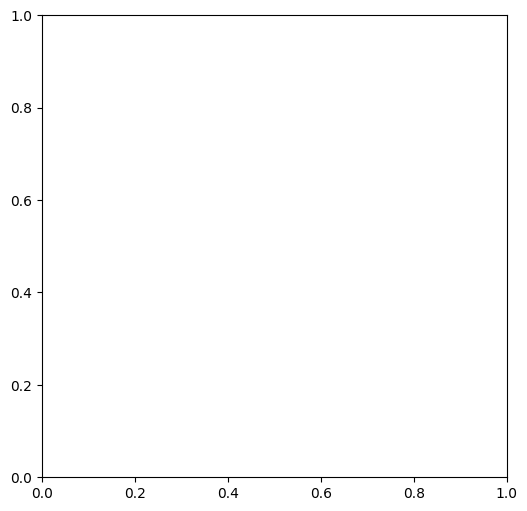

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

x = mpd_df['frameId'].values
y = mpd_df['mean_pairwise_dist'].values

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

def animate(i):
    ax.cla() # clear the previous image
    ax.plot(x[:i], y[:i]) # plot the line
    ax.set_xlim([2, 109]) # fix the x axis
    ax.set_ylim([.9*np.min(y), 1.1*np.max(y)]) # fix the y axis
    ax.set_ylabel('Defensive Congestion Index')
    ax.set_xlabel('Frame')
    ax.set_title('Defensive Congestion Index (by frame)')
    #ax.set_xticks([1,2,3,4,5])

anim = animation.FuncAnimation(fig, animate, frames = len(x) + 1, interval = 1, blit = False)
plt.show()

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
anim.save('image/line.gif', writer=writer)


#plt.show()

In [40]:
'''
dt = 0.01
tfinal = 1
x0 = 0

sqrtdt = np.sqrt(dt)
n = int(tfinal/dt)
xtraj = np.zeros(n+1, float)
trange = np.linspace(start=0,stop=tfinal ,num=n+1)
xtraj[0] = x0

for i in range(n):
    xtraj[i+1] = xtraj[i] + np.random.normal()

x = trange
y = xtraj

# animation line plot example

print(len(x),len(y),x)

'''

'\ndt = 0.01\ntfinal = 1\nx0 = 0\n\nsqrtdt = np.sqrt(dt)\nn = int(tfinal/dt)\nxtraj = np.zeros(n+1, float)\ntrange = np.linspace(start=0,stop=tfinal ,num=n+1)\nxtraj[0] = x0\n\nfor i in range(n):\n    xtraj[i+1] = xtraj[i] + np.random.normal()\n\nx = trange\ny = xtraj\n\n# animation line plot example\n\nprint(len(x),len(y),x)\n\n'

In [41]:
import imageio

In [42]:
def combine_gifs(gif1_path, gif2_path, output_path):
    # Read GIFs
    gif1 = imageio.get_reader(gif1_path)
    gif2 = imageio.get_reader(gif2_path)

    # Get frame duration (assuming both GIFs have the same frame duration)
    duration = gif1.get_meta_data()["duration"]

    # Create a writer for the combined GIF
    combined_gif_writer = imageio.get_writer(output_path, duration=duration, loop=0)

    combined_frame = None
    # Combine frames side by side and write
    for frame1, frame2 in zip(gif1, gif2):
        combined_frame = imageio.core.util.Image(
            np.concatenate([frame2, frame1], axis=1)
        )
        combined_gif_writer.append_data(combined_frame)

    # pause on the last frame for 5 frames
    for i in range(5):
        combined_gif_writer.append_data(combined_frame)

    # Close
    combined_gif_writer.close()
    gif1.close()
    gif2.close()



In [43]:
gif1 = imageio.get_reader('image/harris.gif')
gif2 = imageio.get_reader('image/line.gif')

In [44]:
combine_gifs('image/line.gif','image/harris.gif','image/comb.gif')